In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dbn_ppl_rl import *

/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
names = [ "small_buff", "large_buff", "medium", "small_buff_small_expl"]

In [ ]:
import os

trainings = []
for name in names:
    tr = []
    for i in range(30):
        file_path = f"data/raw/dqn/{name}-{i}_object.pkl"
        if os.path.exists(file_path):
            tr.append(Training.load(file_path))
    trainings.append(tr)

In [4]:
name_to_symbol = {
    "large_buff": "DQN_L",
    "small_buff": "DQN_S",
    "medium": "DQN_M",
    "small_buff_small_expl": "DQN_SS"
}

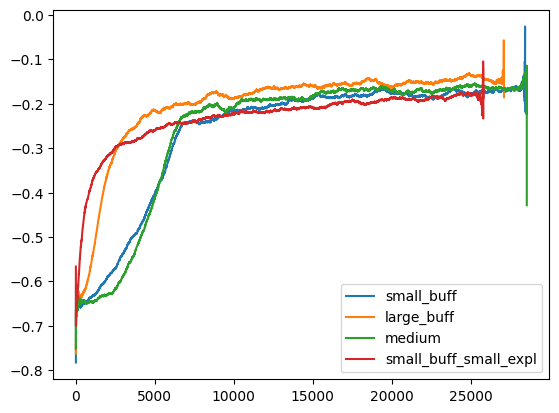

In [41]:
import numpy as np
import json

for (i, name) in enumerate(names):
    tr = trainings[i] 
    episode_rewards = [[np.sum(ep.rewards) for ep in t.episodes] for t in tr]
    min_length = min(len(rewards) for rewards in episode_rewards)
    mean_reward = np.mean([rewards[:min_length] for rewards in episode_rewards], axis=0)

    # Initialize dynamically smoothed array
    smoothed_mean = np.zeros_like(mean_reward)
    smoothed_std_low = np.zeros_like(mean_reward)
    smoothed_std_high = np.zeros_like(mean_reward)

    max_window_size = 1000
    n = len(mean_reward)

    # Apply growing window size smoothing
    for idx in range(n):
        # Determine the dynamic window size
        window_size = min(max_window_size, idx + 1, n - idx)
        half_window = window_size // 2

        # Compute the start and end of the window
        start = max(0, idx - half_window)
        end = min(n, idx + half_window + 1)

        # Calculate the smoothed values for the current window
        window = mean_reward[start:end]
        smoothed_mean[idx] = np.mean(window)
        st = np.std(window)
        smoothed_std_low[idx] = smoothed_mean[idx] - st
        smoothed_std_high[idx] = smoothed_mean[idx] + st

    # Keys for plotting (original data indices)
    length = len(mean_reward)
    keys_of_smoothed = list(range(len(mean_reward)))

    # Create the structure
    means_type = {
        "individual_runs": [[float(x) for x in ep] for ep in episode_rewards],
        "mean_rewards": [float(x) for x in mean_reward],
        "smoothed_mean": [float(x) for x in smoothed_mean][50:length-200][::120],
        "smoothed_std_low": [float(x) for x in smoothed_std_low][50:length-200][::120],
        "smoothed_std_high": [float(x) for x in smoothed_std_high][50:length-200][::120],
        "keys_of_smoothed": keys_of_smoothed[50:length-200][::120],
        "name": name_to_symbol[name],
        "info": {}
    }

    # Save as JSON
    with open(f"json/dqn/{name}.json", 'w') as f:
        json.dump(means_type, f)

    # Plot the dynamically smoothed mean
    plt.plot(keys_of_smoothed, smoothed_mean, label=name)

plt.legend()
plt.show()
